# Learning by stealing
```text
playing with variational auto encoder to create MNIST digits

unlike an generic auto encoder which only learns a compressed encoding of an input vector, a variational autoencoder learns the parameters of a probability distribution representing the data.

taking code from
https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb

blog post
https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
```

In [2]:
import matplotlib.pyplot as plt
from src.small_tf_vae import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

%matplotlib inline
%autoreload 2

/Users/ophidian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.reset_default_graph()

batch_size = 16 #64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2


## Connecting the encoder to the decoder

In [4]:
sampled, mn, sd = encoder(X_in, keep_prob, n_latent)
dec = decoder(sampled, keep_prob, reshaped_dim, inputs_decoder)

## Computing losses and enforcing a Gaussian latent distribution
(from Felix)

For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs.


In [5]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


0 30.491959 20.765415 9.7265415


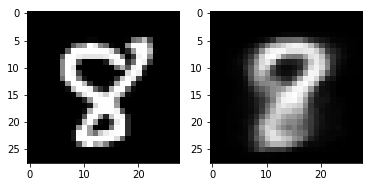

10 38.181934 29.455208 8.726725


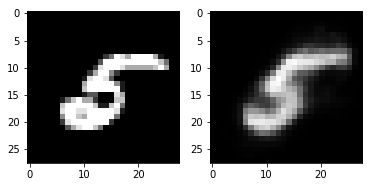

20 31.492682 23.40349 8.089191


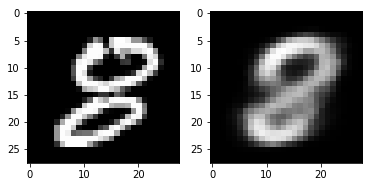

30 32.42736 23.767914 8.659447


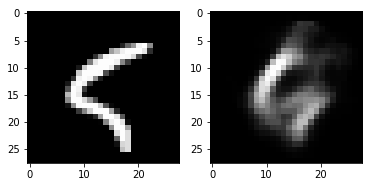

40 34.289917 26.291805 7.9981112


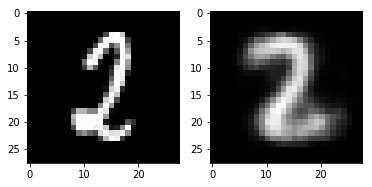

50 40.224113 32.921097 7.303019


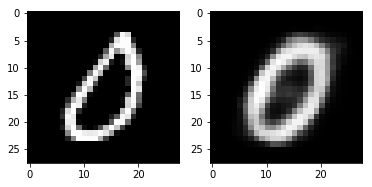

60 29.13813 21.582344 7.5557885


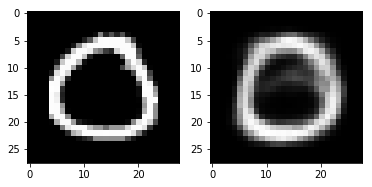

70 35.208847 26.598589 8.610257


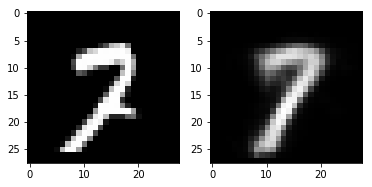

80 32.53839 24.798635 7.7397566


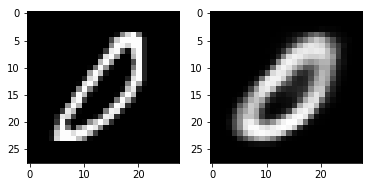

90 39.955025 31.06393 8.891094


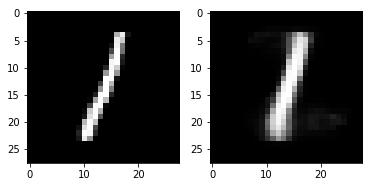

100 37.435513 28.518675 8.916839


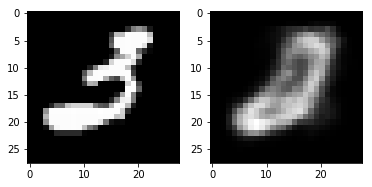

110 37.920677 29.173347 8.74733


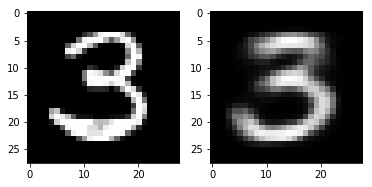

120 34.11726 26.0471 8.070159


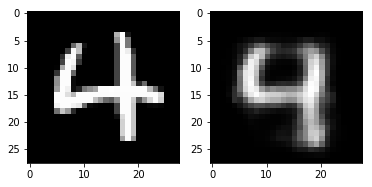

130 36.664577 29.040342 7.624235


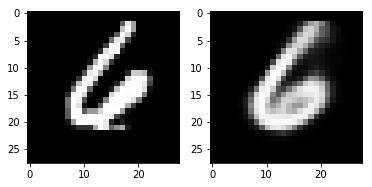

140 32.2634 23.894966 8.368435


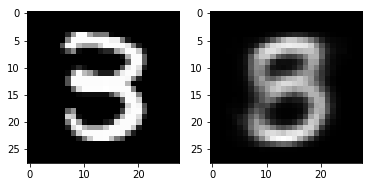

150 31.796711 23.716213 8.080496


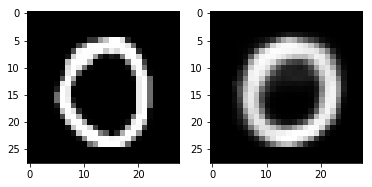

160 36.20447 27.809301 8.395169


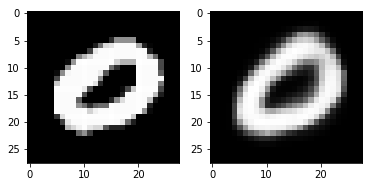

170 31.656948 23.723825 7.9331226


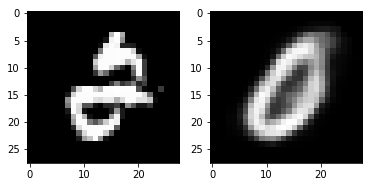

180 34.24323 24.939201 9.304028


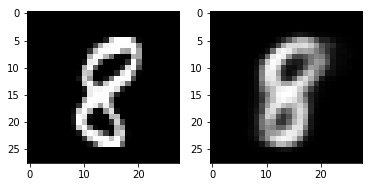

190 34.58091 26.37685 8.204058


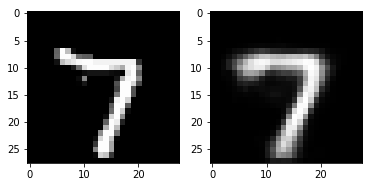

200 37.371014 29.347042 8.023972


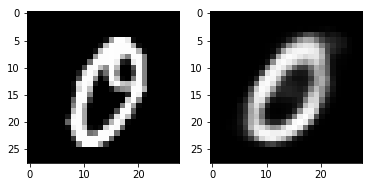

210 37.807114 28.081612 9.725502


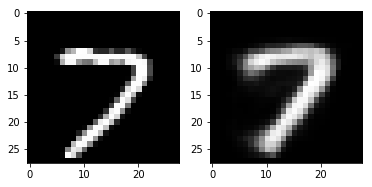

220 37.510815 29.130486 8.38033


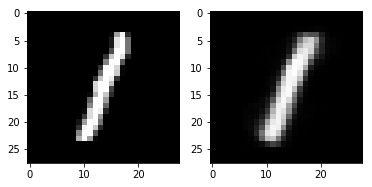

230 36.413208 28.257412 8.155794


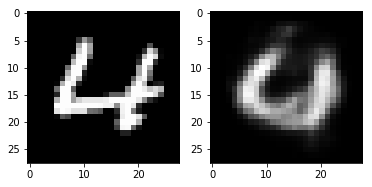

240 35.922886 27.540197 8.382687


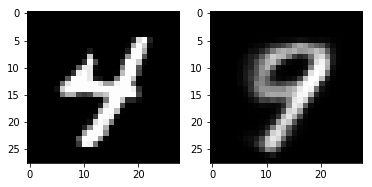

250 32.41377 23.981266 8.432501


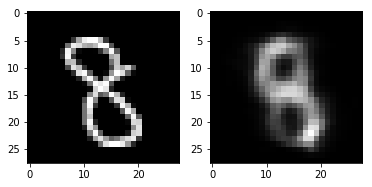

260 34.94732 26.50797 8.439348


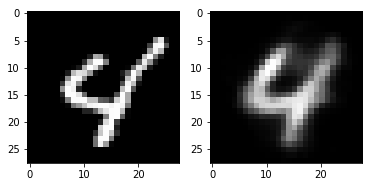

270 32.929764 25.151468 7.7782974


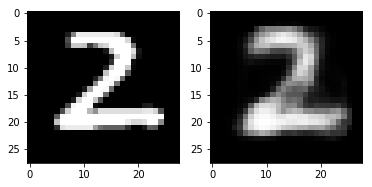

280 31.45493 22.61208 8.842849


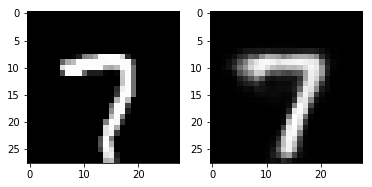

290 30.408297 21.87289 8.535406


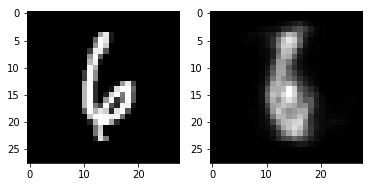

300 33.325634 25.514364 7.81127


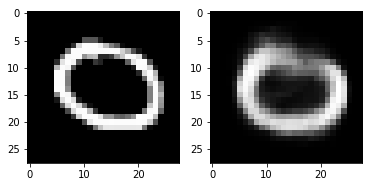

310 36.12513 26.934727 9.190405


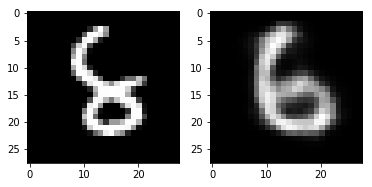

320 31.974154 24.034237 7.9399166


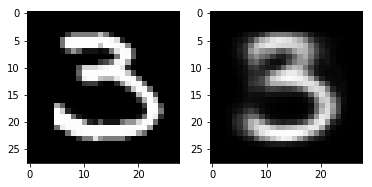

330 31.704262 22.98893 8.71533


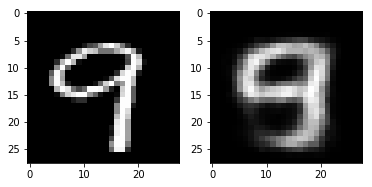

340 36.401024 28.057121 8.343902


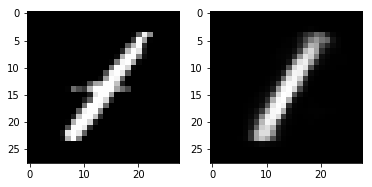

350 35.16838 26.560905 8.607477


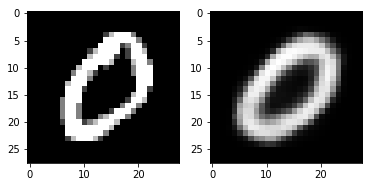

360 38.36798 30.334734 8.03325


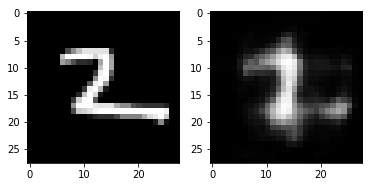

370 30.799858 22.878975 7.920886


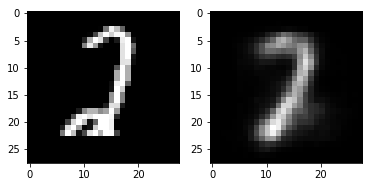

380 36.903114 28.234692 8.668423


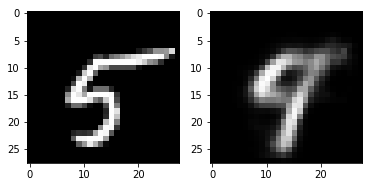

390 29.198572 21.019066 8.179505


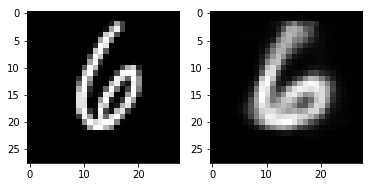

400 31.4786 22.596462 8.882137


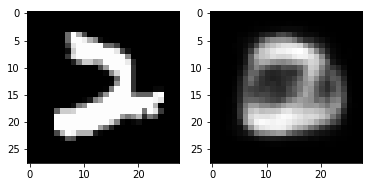

410 33.824226 24.785467 9.038756


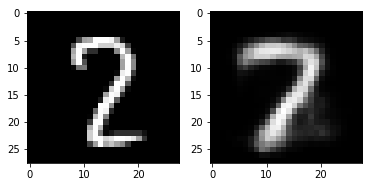

420 33.146065 25.550549 7.595518


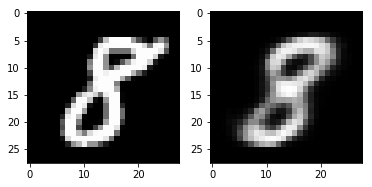

430 28.759129 20.844034 7.9150968


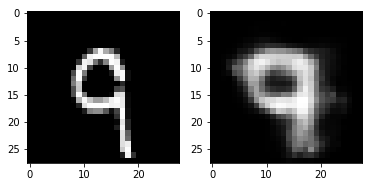

440 33.115524 25.22733 7.888197


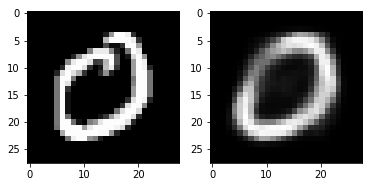

450 35.796104 27.782043 8.014059


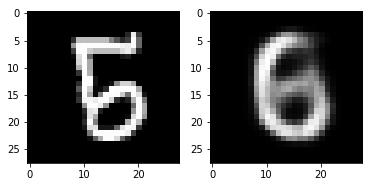

460 32.11521 23.665522 8.449692


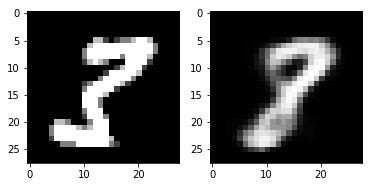

470 30.169882 21.201225 8.968657


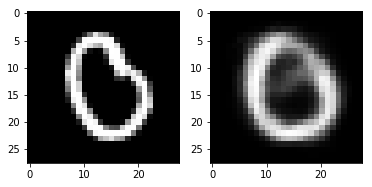

480 32.852562 24.806875 8.045687


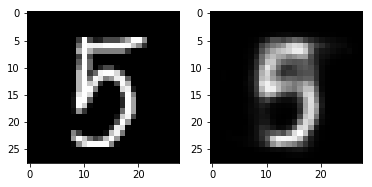

490 29.61353 21.786856 7.8266726


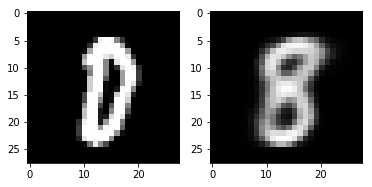

In [12]:
# train_vae(mnist)
steps = 500 #30000
report_interval = 10 #200

for i in range(steps):
    batch = [np.reshape(b, [28, 28]) for b in
             mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch,
                                     Y: batch,
                                     keep_prob: 0.8})

    if not i % report_interval:
        print(i, ls, np.mean(i_ls), np.mean(d_ls))
        ls, d, i_ls, d_ls, mu, sigm = \
            sess.run([loss, dec, img_loss, latent_loss, mn, sd],
                      feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        f, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        ax2.imshow(d[0], cmap='gray')
        plt.show()
